# Import stuff

In [1]:
import os
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import image, masking
from nilearn.input_data import NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_epi, view_img, plot_stat_map
from nilearn.image import threshold_img
from IPython.display import display



# Params

In [2]:
#dirs:
pre_proc_dir = 'data/pre_proc_data'
masks_dir = 'masks'
connectiviity_data_dir = 'data/connectivity_data'
time_series_dir = 'data/time_series'

# file_format:
any_session_file_format = '_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'

# R01 to IDCH mapping:
mapping_R01_to_IDCH = {'222': '101', '183': '102', '216': '103', '192': '104', '251': '105', '206': '106', '180': '107', '184': '108', '169': '109', '207': '110',
                       '159': '111', '115': '112', '114': '113', '232': '114', '173': '115', '171': '117', '215': '118', '265': '119', '177': '120', '269': '121',
                       '261': '122'}

# masks: * mask files should end with _mask.nii.gz
masks_to_apply = ['L_SMA_mask.nii.gz', 'R_SMA_mask.nii.gz', 'L_post_putamen_mask.nii.gz', 'R_post_putamen_mask.nii.gz', 'R_premotor_mask.nii.gz', 'L_premotor_mask.nii.gz', 'L_anterior_caudate_mask.nii.gz', 'R_anterior_caudate_mask.nii.gz', 'vmpfc_mask.nii.gz', 'L_vlpfc_mask.nii.gz', 'R_vlpfc_mask.nii.gz', 'L_anterior_putamen_mask.nii.gz', 'R_anterior_putamen_mask.nii.gz', 'R_frontopolar_mask.nii.gz']

# regions to test connectivity between: * add pairs of regions to test connectivity between
connectivity_regions = [['L_SMA', 'L_post_putamen'], ['R_SMA', 'R_post_putamen'], ['L_premotor', 'L_post_putamen'], ['R_premotor', 'R_post_putamen'], ['L_anterior_caudate', 'vmpfc'], ['R_anterior_caudate', 'vmpfc'], ['L_vlpfc', 'L_post_putamen'], ['R_vlpfc', 'R_post_putamen'], ['L_vlpfc', 'L_anterior_putamen'], ['R_vlpfc', 'R_anterior_putamen'], ['L_vlpfc', 'L_anterior_caudate'], ['R_vlpfc', 'R_anterior_caudate'], ['R_frontopolar', 'R_anterior_caudate'], ['R_frontopolar', 'R_post_putamen'], ['R_post_putamen', 'L_post_putamen'], ['R_anterior_caudate', 'L_anterior_caudate']]


# Create IDCH sub id folders + Extract time series using masks (directly from the data) for each session separately

In [3]:
# get all directories in the root directory
r01_sub_dirs = os.listdir(pre_proc_dir)
r01_sub_dirs = [x for x in r01_sub_dirs if 'MBMFHab' in x]

for dir in r01_sub_dirs:
    sub_dir = os.path.join(pre_proc_dir, dir, 'func')
    
    # get sub R01 id:
    sub_R01_id = dir.split('Hab0')[1][:3]
    # get sub IDCH id:
    sub_IDCH_id = mapping_R01_to_IDCH[sub_R01_id]

    # create a new foler for the sub according to sub_IDCH_id:
    sub_IDCH_dir = os.path.join(time_series_dir, 'sub-' + sub_IDCH_id)
    if not os.path.exists(sub_IDCH_dir):
        os.makedirs(sub_IDCH_dir)

    for mask in masks_to_apply:
        mask_name = mask.split('_mask')[0]
        for session in ['1', '2']:
            input_file = [f for f in os.listdir(sub_dir) if f'{session}{any_session_file_format}' in f][0]
            if not os.path.exists(os.path.join(sub_IDCH_dir, f"sub-{sub_IDCH_id}_IDCH_ses-{session}_{mask_name}_time_series.txt")):
                print(f'>> Extracting time series for sub-{sub_IDCH_id}, session {session}, using {mask}')
                # fslmeants -i <input_file> -o <output_file> -m <mask_file>
                os.system(f'fslmeants -i {os.path.join(sub_dir, input_file)} -o {os.path.join(sub_IDCH_dir, f"sub-{sub_IDCH_id}_IDCH_ses-{session}_{mask_name}_time_series.txt")} -m {os.path.join(masks_dir, mask)}')


In [20]:
sub_R01_id

'269'


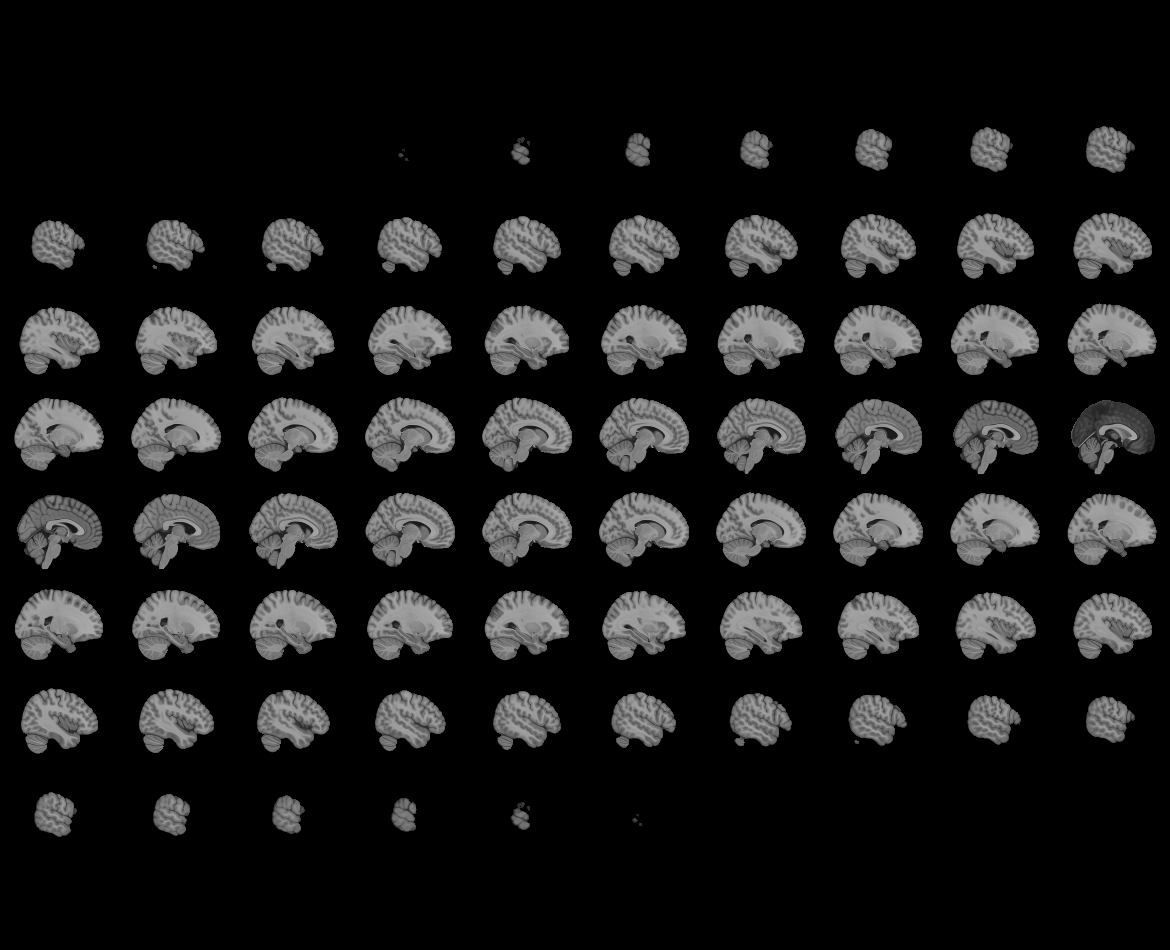
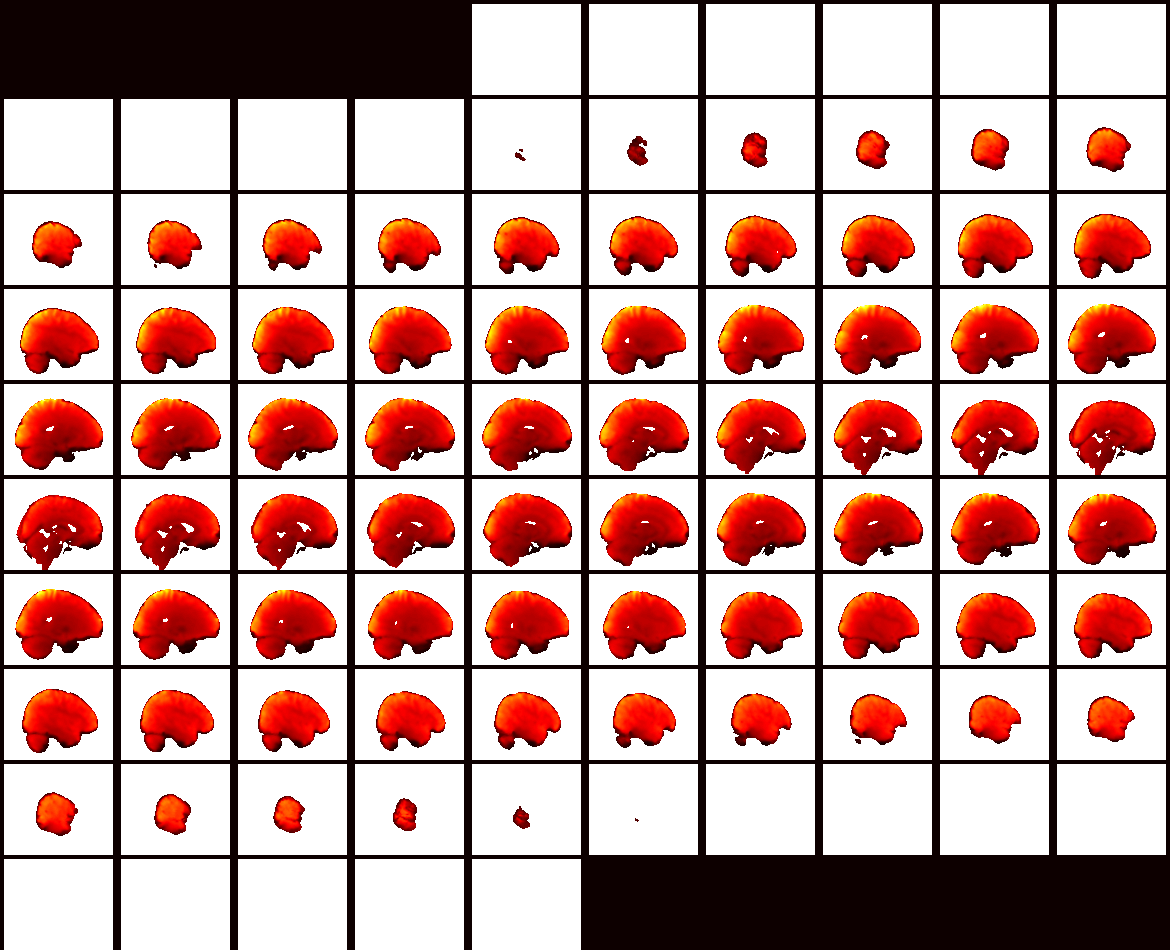

In [40]:
view_img(fmri_img.slicer[..., 50])


In [6]:
# Load the preprocessed fMRI data
# fmri_img = {os.path.join(sub_dir, input_file)}
# fmri_img = 'data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz'
fmri_img = image.load_img('data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz')

# Load the seed time series from the text file
# seed_time_series = np.loadtxt(os.path.join(sub_IDCH_dir, f"sub-{sub_IDCH_id}_IDCH_ses-{session}_{mask_name}_time_series.txt"))
seed_time_series = np.loadtxt(os.path.join("data/time_series/sub-101/", f"sub-{101}_IDCH_ses-{1}_{'R_post_putamen'}_time_series.txt"))

# # standardize the data (per voxel timeseries)
nifti_masker = NiftiMasker(standardize=True)
fmri_data_standardized = nifti_masker.fit_transform(fmri_img)
fmri_data_standardized

# Convert the standardized data back to an image for visualization (if needed)
fmri_img_standardized = nifti_masker.inverse_transform(fmri_data_standardized) ***

# Compute the correlation between the seed time series and each voxel's time series
correlation_measure = ConnectivityMeasure(kind='correlation')


array([[ 0.45884305,  0.7166423 ,  0.77146804, ..., -1.6275238 ,
        -0.97286934, -1.7831957 ],
       [ 0.7924594 ,  1.8362801 ,  1.9871607 , ..., -0.4898534 ,
        -0.58029   , -0.98106265],
       [ 1.9785151 ,  2.874322  ,  2.920648  , ..., -1.3448039 ,
        -1.067457  , -1.6199384 ],
       ...,
       [ 1.4955784 ,  1.9136447 ,  2.0688162 , ..., -0.17015082,
        -0.05156683,  0.04006114],
       [ 1.2292709 ,  0.41676563, -0.15463698, ...,  1.0959383 ,
         0.88495725,  0.86424816],
       [ 1.40988   ,  1.3262768 ,  1.288903  , ...,  0.47674266,
         0.7625594 ,  0.6143533 ]], dtype=float32)

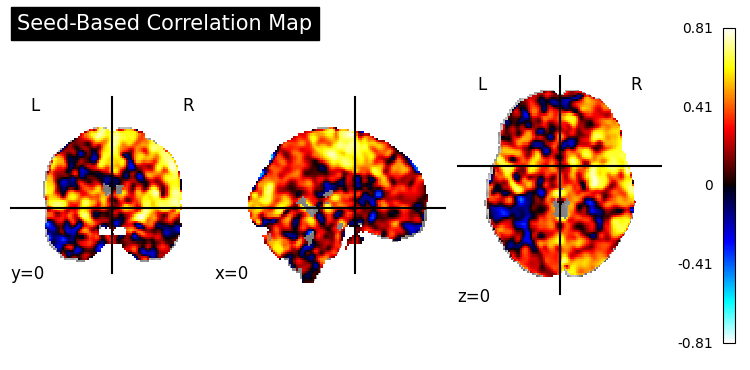

In [4]:
# Path to your 4D fMRI data
fmri_img_path = 'data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz'

# Load the seed time series
seed_time_series = np.loadtxt(os.path.join("data/time_series/sub-101/", f"sub-{101}_IDCH_ses-{1}_{'R_post_putamen'}_time_series.txt"))

# Initialize the NiftiMasker with standardization enabled, passing the file path
nifti_masker = NiftiMasker(standardize=True)

# Apply the masker directly to the file path (this reads and processes the image)
fmri_data_standardized = nifti_masker.fit_transform(fmri_img_path)

# Compute voxel-wise correlations with the seed time series
correlation_measure = ConnectivityMeasure(kind='correlation')
fmri_data_standardized_t = fmri_data_standardized.T
correlation_matrix = np.array([np.corrcoef(seed_time_series, voxel_time_series)[0, 1] for voxel_time_series in fmri_data_standardized_t])

# Convert correlation matrix back to a 3D image
correlation_img = nifti_masker.inverse_transform(correlation_matrix)

# Visualize the correlation map
plot_stat_map(correlation_img, title='Seed-Based Correlation Map', display_mode='ortho', cut_coords=(0, 0, 0))

# Optionally save the correlation map
# correlation_img.to_filename('seed_based_correlation_map.nii.gz')


In [8]:
fmri_data_standardized

fmri_data_standardized_img = nifti_masker.inverse_transform(fmri_data_standardized)

# Save to nii file
# fmri_data_standardized.to_filename('sub-101_ses-1_PY_TEST.nii.gz')

In [ ]:
fslmaths data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz -Tmean zzz_mean_image.nii.gz

fslmaths data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz -Tstd zzz_std_image.nii.gz

fslmaths data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz -sub zzz_mean_image.nii.gz -div zzz_std_image.nii.gz zzz_FSL_normalized_data.nii.gz


fslmaths sub-101_ses-1_PY_TEST.nii.gz -sub zzz_FSL_normalized_data.nii.gz PY_FSL_DIFF.nii.gz



In [9]:
fmri_data_standardized_img.shape

(91, 109, 91, 600)

In [10]:
fmri_data_standardized_img.to_filename('sub-101_ses-1_PY_TEST.nii.gz')

In [8]:
fmri_data_standardized.shape

(600, 228483)

In [11]:
# fmri_img_standardized = nifti_masker.inverse_transform(fmri_data_standardized)
# save image:
fmri_img_standardized.to_filename('data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain_standardized_TEST.nii.gz')
fmri_img_standardized.shape

(91, 109, 91, 600)

In [5]:
seed_time_series.shape

(600,)

In [24]:
fmri_data_standardized.shape

(600, 228483)

Original Correlation (with Simpson's Paradox): -0.33
Correlation within Session 1: 0.30
Correlation within Session 2: 0.82
Average Correlation (Separate Sessions): 0.56
Correlation after Normalization: 0.56
Correlation after Subtracting Average: 0.70


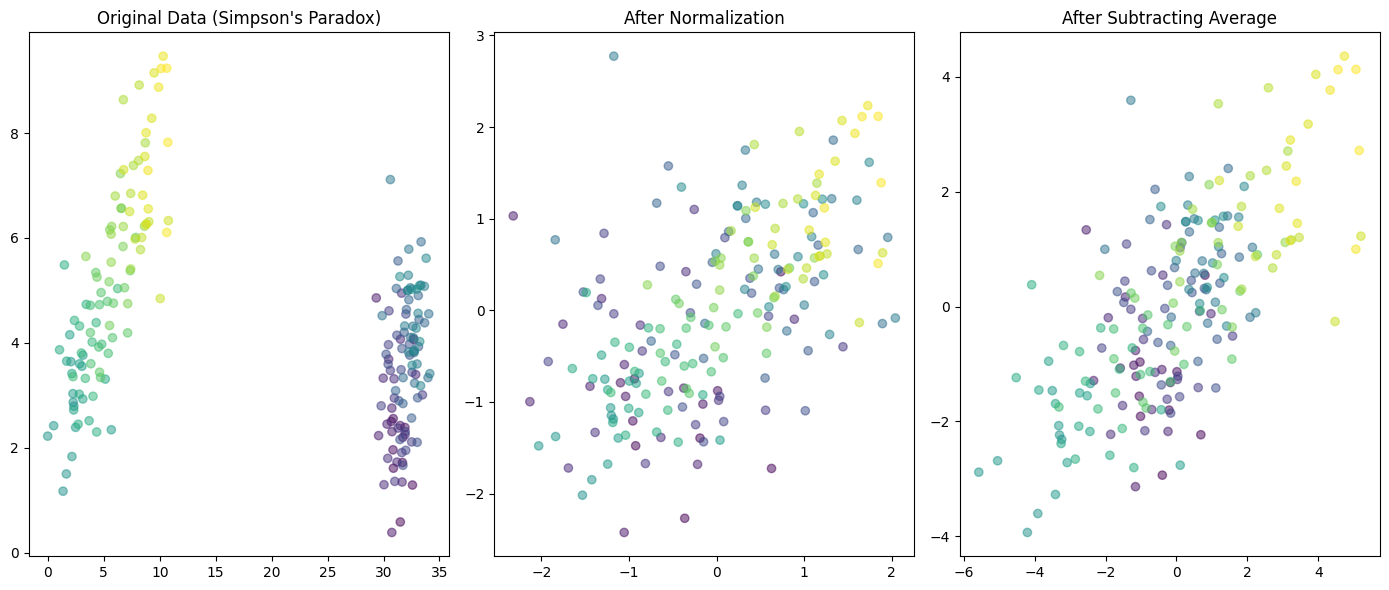

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate time series data for two brain regions over two sessions
np.random.seed(42)

# Time points
time_points_session1 = np.arange(0, 100)
time_points_session2 = np.arange(100, 200)

# Session 1: Positive correlation
region1_session1 = np.linspace(31, 33, 100) + np.random.normal(scale=1, size=100)
region2_session1 = np.linspace(2, 5, 100) + np.random.normal(scale=1, size=100)

# Session 2: Negative correlation
region1_session2 = np.linspace(1, 10, 100) + np.random.normal(scale=1, size=100)
region2_session2 = np.linspace(2, 8, 100) + np.random.normal(scale=1, size=100)

# Concatenate the sessions
region1_combined = np.concatenate([region1_session1, region1_session2])
region2_combined = np.concatenate([region2_session1, region2_session2])
time_points_combined = np.concatenate([time_points_session1, time_points_session2])

# Original correlation (causing Simpson's Paradox)
original_correlation = np.corrcoef(region1_combined, region2_combined)[0, 1]

# Correlation within each session separately
corr_session1 = np.corrcoef(region1_session1, region2_session1)[0, 1]
corr_session2 = np.corrcoef(region1_session2, region2_session2)[0, 1]
average_separate_correlation = (corr_session1 + corr_session2) / 2

# Normalize each session separately (z-score normalization)
from scipy.stats import zscore

region1_combined_normalized = np.concatenate([zscore(region1_session1), zscore(region1_session2)])
region2_combined_normalized = np.concatenate([zscore(region2_session1), zscore(region2_session2)])
normalized_correlation = np.corrcoef(region1_combined_normalized, region2_combined_normalized)[0, 1]

# Subtract the average from each session
region1_combined_subtracted = np.concatenate([region1_session1-np.mean(region1_session1), region1_session2-np.mean(region1_session2)])
region2_combined_subtracted = np.concatenate([region2_session1-np.mean(region2_session1), region2_session2-np.mean(region2_session2)])
subtracted_correlation = np.corrcoef(region1_combined_subtracted, region2_combined_subtracted)[0, 1]

# Display results
print(f"Original Correlation (with Simpson's Paradox): {original_correlation:.2f}")
print(f"Correlation within Session 1: {corr_session1:.2f}")
print(f"Correlation within Session 2: {corr_session2:.2f}")
print(f"Average Correlation (Separate Sessions): {average_separate_correlation:.2f}")
print(f"Correlation after Normalization: {normalized_correlation:.2f}")
print(f"Correlation after Subtracting Average: {subtracted_correlation:.2f}")

# Plot to visualize
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(region1_combined, region2_combined, c=time_points_combined, cmap='viridis', alpha=0.5)
plt.title("Original Data (Simpson's Paradox)")

plt.subplot(1, 3, 2)
plt.scatter(region1_combined_normalized, region2_combined_normalized, c=time_points_combined, cmap='viridis', alpha=0.5)
plt.title("After Normalization")

plt.subplot(1, 3, 3)
plt.scatter(region1_combined_subtracted, region2_combined_subtracted, c=time_points_combined, cmap='viridis', alpha=0.5)
plt.title("After Subtracting Average")

plt.tight_layout()
plt.show()


# Calculate correlations (connectivity) and plot each subject's timeseries data

In [6]:
# get sub dirs:
IDCH_sub_dirs = [x for x in os.listdir(time_series_dir) if 'sub-' in x]
# sort the sub dirs:
IDCH_sub_dirs.sort()

# List to collect data for DataFrame
per_region_data = {}

# Loop over the subject directories in the root directory
for region_pair in connectivity_regions:
    print(f"Analyzing connectivity between {region_pair[0]} and {region_pair[1]}")
    region_df = []
    for subj in IDCH_sub_dirs:
        subject_dir = os.path.join(time_series_dir, subj)
        sub_ID = subj.split('-')[1]
        print(f"Analyzing subject {sub_ID}")

        # Get the data for both regions:
        reg1_ses1_dir = os.path.join(subject_dir, f'sub-{sub_ID}_IDCH_ses-1_{region_pair[0]}_time_series.txt')
        reg1_ses2_dir = os.path.join(subject_dir, f'sub-{sub_ID}_IDCH_ses-2_{region_pair[0]}_time_series.txt')
        reg2_ses1_dir = os.path.join(subject_dir, f'sub-{sub_ID}_IDCH_ses-1_{region_pair[1]}_time_series.txt')
        reg2_ses2_dir = os.path.join(subject_dir, f'sub-{sub_ID}_IDCH_ses-2_{region_pair[1]}_time_series.txt')

        reg1_ses1_ts_data = np.loadtxt(reg1_ses1_dir)
        reg1_ses2_ts_data = np.loadtxt(reg1_ses2_dir)
        reg2_ses1_ts_data = np.loadtxt(reg2_ses1_dir)
        reg2_ses2_ts_data = np.loadtxt(reg2_ses2_dir)

        # Calculate the Pearson correlation between the time series
        correlation_ses1, p_val_ses_1 = pearsonr(reg1_ses1_ts_data, reg2_ses1_ts_data)
        z_score_ses1 = 0.5 * np.log((1 + correlation_ses1) / (1 - correlation_ses1))
        correlation_ses2, p_val_ses_2 = pearsonr(reg1_ses2_ts_data, reg2_ses2_ts_data)
        z_score_ses2 = 0.5 * np.log((1 + correlation_ses2) / (1 - correlation_ses2))

        # Print correlation for the subject:
        print(f">> Subject {sub_ID}: correlation between {region_pair[0]} and {region_pair[1]}:\n - session 1: r={correlation_ses1}, p={p_val_ses_1}, z-score={z_score_ses1}\n - session 2: r={correlation_ses2}, p={p_val_ses_2}, z-score={z_score_ses2}")

        # # Scatterplot
        # fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        # axs[0].scatter(reg1_ses1_ts_data, reg2_ses1_ts_data)
        # axs[0].set_title(f'Scatterplot for Subject {sub_ID} - Session 1')
        # axs[0].set_xlabel(region_pair[0])
        # axs[0].set_ylabel(region_pair[1])
        # axs[1].scatter(reg1_ses2_ts_data, reg2_ses2_ts_data)
        # axs[1].set_title(f'Scatterplot for Subject {sub_ID} - Session 2')
        # axs[1].set_xlabel(region_pair[0])
        # axs[1].set_ylabel(region_pair[1])
        # plt.show()

        # # Line Plot for the Time-Series Data
        # fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        # axs[0].plot(reg1_ses1_ts_data, color='red', label=region_pair[0])
        # axs[0].plot(reg2_ses1_ts_data, color='blue', label=region_pair[1])
        # axs[0].set_title(f'Time Series for Subject {sub_ID} - Session 1')
        # axs[0].set_xlabel('Time')
        # axs[0].set_ylabel('BOLD Signal')
        # axs[0].legend()
        # axs[1].plot(reg1_ses2_ts_data, color='red', label=region_pair[0])
        # axs[1].plot(reg2_ses2_ts_data, color='blue', label=region_pair[1])
        # axs[1].set_title(f'Time Series for Subject {sub_ID} - Session 2')
        # axs[1].set_xlabel('Time')
        # axs[1].set_ylabel('BOLD Signal')
        # axs[1].legend()
        # plt.show()

        #Append the data to list (with means)
        region_df.append({"subID": sub_ID, "corr": np.mean([correlation_ses1, correlation_ses2]), "p_val": np.mean([p_val_ses_1, p_val_ses_2]), "z_score": np.mean([z_score_ses1, z_score_ses2])})

    # keep data
    region_connectivity_df = pd.DataFrame(region_df)
    per_region_data[region_pair[0] + "_" + region_pair[1]] = region_connectivity_df

    # save region_connectivity_df to csv
    region_connectivity_df.to_csv(f'{connectiviity_data_dir}/{region_pair[0]}_{region_pair[1]}_connectivity.csv', index=False)

    # # Plot the histogram of the Z-scores
    # plt.hist(region_connectivity_df.z_score, alpha=0.6, color='g')
    # plt.title("Histogram of Z-scores")
    # plt.show()

    # display(region_connectivity_df)


# create a data frame that has only the connectivity score (z-score) for each region pair (and the subject ID):\
connectivity_df = pd.DataFrame(columns=['subID'])
for key in per_region_data.keys():
    connectivity_score = per_region_data[key][['subID', 'z_score']]
    connectivity_score = connectivity_score.rename(columns={'z_score': key})
    connectivity_df = pd.merge(connectivity_df, connectivity_score, on='subID', how='outer')
# save the connectivity_df to csv
connectivity_df.to_csv(f'{connectiviity_data_dir}/all_connectivity_scores.csv', index=False)
display(connectivity_df)

Analyzing connectivity between L_SMA and L_post_putamen
Analyzing subject 101
>> Subject 101: correlation between L_SMA and L_post_putamen:
 - session 1: r=0.6974700840156763, p=1.3479936196041346e-88, z-score=0.8623570336628756
 - session 2: r=0.6967995325622821, p=2.3243244018746332e-88, z-score=0.8610524661601807
Analyzing subject 102
>> Subject 102: correlation between L_SMA and L_post_putamen:
 - session 1: r=0.5241229811376744, p=1.2189686019082915e-43, z-score=0.5820074860801172
 - session 2: r=0.7776485740091901, p=1.2331480612295025e-122, z-score=1.039393806958802
Analyzing subject 103
>> Subject 103: correlation between L_SMA and L_post_putamen:
 - session 1: r=0.8375730162730388, p=3.8548754227928483e-159, z-score=1.21298619858267
 - session 2: r=0.4888643257896711, p=2.2800702537756377e-37, z-score=0.5345669243194686
Analyzing subject 104
>> Subject 104: correlation between L_SMA and L_post_putamen:
 - session 1: r=0.6770083862472944, p=1.1646095530647916e-81, z-score=0.823

,subID,L_SMA_L_post_putamen,R_SMA_R_post_putamen,L_premotor_L_post_putamen,R_premotor_R_post_putamen,L_anterior_caudate_vmpfc,R_anterior_caudate_vmpfc,L_vlpfc_L_post_putamen,R_vlpfc_R_post_putamen,L_vlpfc_L_anterior_putamen,R_vlpfc_R_anterior_putamen,L_vlpfc_L_anterior_caudate,R_vlpfc_R_anterior_caudate,R_frontopolar_R_anterior_caudate,R_frontopolar_R_post_putamen,R_post_putamen_L_post_putamen,R_anterior_caudate_L_anterior_caudate
0,101,0.861705,0.999613,0.803747,1.094074,0.164962,0.177019,0.181933,0.735587,0.048225,0.502105,0.310097,0.508337,0.544146,0.630043,0.854171,0.900072
1,102,0.810701,0.758202,0.819513,0.931494,0.487960,0.380596,0.460014,0.509718,0.520952,0.652724,0.552395,0.558526,0.459935,0.203949,0.598096,0.903952
2,103,0.873777,1.096994,0.954003,1.029812,0.856512,0.897386,0.674891,0.508110,0.468538,0.633722,0.583724,0.918458,0.829468,0.628293,1.016094,1.021193
3,104,0.704080,0.628146,0.550460,0.607973,0.235184,0.156505,0.167036,0.515936,0.134439,0.407859,0.374569,0.525065,0.487885,0.341469,1.058985,0.742220
4,105,0.469796,0.380984,0.473460,0.496950,0.423217,0.335404,0.375224,0.510528,0.308776,0.358326,0.452012,0.410962,0.402510,0.339243,0.893498,1.322827
5,106,0.618276,0.622709,0.640455,0.393372,0.399778,0.396591,0.617641,0.252032,0.483515,0.408289,0.458778,0.435492,0.621021,0.236597,0.607455,0.677879
6,107,0.858922,0.734600,0.914783,0.825037,0.282838,0.347432,0.261609,0.096004,0.228200,-0.087966,0.335756,0.146385,0.638945,0.384664,0.754974,0.998592
7,108,0.824334,0.966774,0.975304,1.107904,0.941516,1.119977,0.494375,0.963547,0.497622,0.876070,0.735241,1.037964,0.948543,0.730018,0.784545,1.522720
8,109,0.647729,0.743506,0.621091,0.890840,0.323459,0.322118,0.369290,0.645006,0.303662,0.548014,0.519355,0.515260,0.510092,0.562172,0.803852,0.779438
9,110,0.931577,0.925478,0.894033,1.148456,0.589581,0.720736,0.401800,0.824453,0.367534,0.666387,0.569057,0.955317,0.667636,0.643407,0.909383,1.137353


In [7]:
connectivity_df
# show summary:
connectivity_df.describe()

,L_SMA_L_post_putamen,R_SMA_R_post_putamen,L_premotor_L_post_putamen,R_premotor_R_post_putamen,L_anterior_caudate_vmpfc,R_anterior_caudate_vmpfc,L_vlpfc_L_post_putamen,R_vlpfc_R_post_putamen,L_vlpfc_L_anterior_putamen,R_vlpfc_R_anterior_putamen,L_vlpfc_L_anterior_caudate,R_vlpfc_R_anterior_caudate,R_frontopolar_R_anterior_caudate,R_frontopolar_R_post_putamen,R_post_putamen_L_post_putamen,R_anterior_caudate_L_anterior_caudate
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.726515,0.784335,0.770932,0.903702,0.458876,0.461924,0.416005,0.564997,0.387021,0.516668,0.480905,0.557914,0.632806,0.494461,0.777609,0.937876
std,0.155917,0.256746,0.216703,0.318235,0.223155,0.249865,0.199812,0.249829,0.209575,0.267145,0.202522,0.271339,0.181973,0.270991,0.208409,0.287544
min,0.324343,0.380984,0.370459,0.393372,0.151364,0.156505,0.167036,0.096004,0.048225,-0.087966,0.088357,0.075391,0.399503,0.067324,0.420960,0.456357
25%,0.633084,0.628146,0.613370,0.662073,0.282838,0.315673,0.305851,0.420503,0.303662,0.358326,0.335756,0.410962,0.485402,0.339243,0.598148,0.742220
50%,0.754052,0.743506,0.795677,0.890840,0.423217,0.380596,0.369290,0.511376,0.345340,0.469134,0.473988,0.508337,0.601306,0.510313,0.789055,0.903952
75%,0.847096,0.966774,0.914783,1.094074,0.589581,0.616265,0.494375,0.744818,0.483515,0.666387,0.569057,0.812016,0.829468,0.630043,0.893498,1.137353
max,0.931577,1.352662,1.163427,1.588450,0.941516,1.119977,0.852436,0.963547,0.824507,1.108253,0.861155,1.037964,0.952395,1.297183,1.165961,1.522720
